Initial preparation by Valery Ilin

Modified by: Elvira Zainulina

In [181]:
import pyrealsense2 as rs
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
from mpl_toolkits.mplot3d import Axes3D

# Collecting frames for next dev

In [182]:
count_of_frames = 15
frames_between_frames_D435 = 20

# Iitial configs

In [188]:
# data filenames
d435_filename = '../data/D435.bag'
t265_filename = '../data/T265.bag'

In [189]:
# config fo D435
cfg_d435 = rs.config()
cfg_d435.enable_device_from_file(d435_filename)
cfg_d435.enable_stream(rs.stream.depth, 848, 480, rs.format.z16, 30)
pipe_d435 = rs.pipeline()
pipe_d435.start(cfg_d435)


In [190]:
# config fo T265
cfg_t265 = rs.config()
cfg_t265.enable_device_from_file(t265_filename)
cfg_t265.enable_stream(rs.stream.pose)
pipe_t265 = rs.pipeline()
pipe_t265.start(cfg_t265)

## Collecting frames

In [262]:
# rewind
for i in range(frames_between_frames_D435*count_of_frames*2):
    pipe_d435.wait_for_frames()

In [191]:
d435_frames = []
while len(d435_frames) != count_of_frames:
    for i in range(frames_between_frames_D435):
        depth_frame = pipe_d435.wait_for_frames().get_depth_frame()
    d435_frames.append(depth_frame)

In [192]:
pose_frame = None
pose_frame_time = -1
thresh = 7
t265_frames = []
t265_frames_temp = []
n = 0

for i, depth_frame in enumerate(d435_frames):
    depth_frame_time = depth_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) > thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        pose_frame_time = pose_frame.get_timestamp()
    while abs(depth_frame_time-pose_frame_time) <= thresh:
        pose_frame = pipe_t265.wait_for_frames().get_pose_frame()
        t265_frames_temp.append(pose_frame)
        pose_frame_time = pose_frame.get_timestamp()

    min_int_index = 0
    min_interval = thresh * 2
    for ind_pose, temp_pose in enumerate(t265_frames_temp):
        if abs(depth_frame_time-temp_pose.get_timestamp())<min_interval:
            min_interval = abs(depth_frame_time-temp_pose.get_timestamp())
            min_int_index = ind_pose
    t265_frames.append(t265_frames_temp[min_int_index])
    

## Test for frames

In [193]:
def count_diff_frames(frames):
    prev_frame = None
    for i, frame in enumerate(frames):
        if prev_frame is not None:
            print("Difference bw {0} and {1} frames is {2:.4f} ms".format(i, i-1, frame.get_timestamp()-prev_frame.get_timestamp()))
        prev_frame = frame

In [194]:
def get_diff_sensors(frames1, frames2):
    if len(frames1) != len(frames2):
        return
    else:
        for i in range(len(frames1)):
            print("Difference bw frames1[{0}] and frames2[{0}] frames is {1:.4f} ms".format(i, frames1[i].get_timestamp()-frames2[i].get_timestamp()))
        

In [195]:
count_diff_frames(d435_frames)
count_diff_frames(t265_frames)

Difference bw 1 and 0 frames is 667.0588 ms
Difference bw 2 and 1 frames is 667.7312 ms
Difference bw 3 and 2 frames is 666.4497 ms
Difference bw 4 and 3 frames is 667.0574 ms
Difference bw 5 and 4 frames is 667.0862 ms
Difference bw 6 and 5 frames is 667.0806 ms
Difference bw 7 and 6 frames is 667.1038 ms
Difference bw 8 and 7 frames is 667.3169 ms
Difference bw 9 and 8 frames is 666.7520 ms
Difference bw 10 and 9 frames is 667.0439 ms
Difference bw 11 and 10 frames is 667.1377 ms
Difference bw 12 and 11 frames is 667.1108 ms
Difference bw 13 and 12 frames is 667.0239 ms
Difference bw 14 and 13 frames is 667.0972 ms
Difference bw 1 and 0 frames is 664.7642 ms
Difference bw 2 and 1 frames is 669.8579 ms
Difference bw 3 and 2 frames is 664.9294 ms
Difference bw 4 and 3 frames is 669.9065 ms
Difference bw 5 and 4 frames is 664.8928 ms
Difference bw 6 and 5 frames is 669.9475 ms
Difference bw 7 and 6 frames is 664.8262 ms
Difference bw 8 and 7 frames is 669.8938 ms
Difference bw 9 and 8 f

In [196]:
get_diff_sensors(d435_frames, t265_frames)

Difference bw frames1[0] and frames2[0] frames is -0.8223 ms
Difference bw frames1[1] and frames2[1] frames is 1.4724 ms
Difference bw frames1[2] and frames2[2] frames is -0.6543 ms
Difference bw frames1[3] and frames2[3] frames is 0.8660 ms
Difference bw frames1[4] and frames2[4] frames is -1.9832 ms
Difference bw frames1[5] and frames2[5] frames is 0.2102 ms
Difference bw frames1[6] and frames2[6] frames is -2.6567 ms
Difference bw frames1[7] and frames2[7] frames is -0.3792 ms
Difference bw frames1[8] and frames2[8] frames is -2.9561 ms
Difference bw frames1[9] and frames2[9] frames is -1.1350 ms
Difference bw frames1[10] and frames2[10] frames is 0.9648 ms
Difference bw frames1[11] and frames2[11] frames is -1.8037 ms
Difference bw frames1[12] and frames2[12] frames is 0.4238 ms
Difference bw frames1[13] and frames2[13] frames is -2.4375 ms
Difference bw frames1[14] and frames2[14] frames is -0.3105 ms


# Analysis

## Helpers

In [197]:
import time
from functools import wraps

def timing(f):
    @wraps(f)
    def wrap(*args, **kw):
        time_start = time.time()
        result = f(*args, **kw)
        time_end = time.time()
        print('----------func:%r took: %2.4f sec' % (f.__name__, time_end-time_start))
        return result
    return wrap

In [198]:
tm_T265toD435 = np.array([[0.999968402, -0.006753626, -0.004188075, -0.015890727],
                          [-0.006685408, -0.999848172, 0.016093893, 0.028273059],
                          [-0.004296131, -0.016065384, -0.999861654, -0.009375589],
                          [0, 0, 0, 1]])

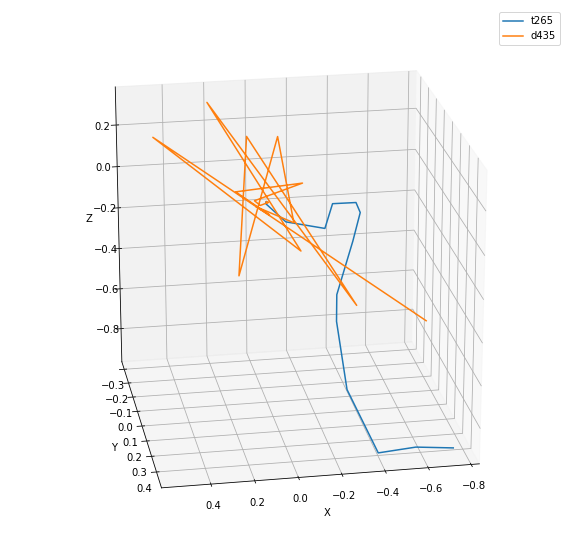

In [199]:
# Graph plot
t265 = np.load('../logs/points_trajectory_T265.npy') #np array coords
d435 = np.load('../logs/points_trajectory_D435.npy')/1 # np array coords
# before = 10
before = d435.shape[0]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(t265[:before, 0], t265[:before, 1], t265[:before, 2], label='t265')
ax.plot(d435[:before, 0], d435[:before, 1], d435[:before, 2], label='d435')
ax.view_init(elev=22, azim=80)
plt.legend()

## Functions

In [200]:
def get_transformation265(pose):
    data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_dcm())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [201]:
get_transformation265(t265_frames[0])

array([[ 0.67560929,  0.3674369 , -0.63917307, -0.219076  ],
       [ 0.03740873,  0.8487561 ,  0.52745964,  0.347813  ],
       [ 0.73631018, -0.38026728,  0.55968216,  0.19687   ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [202]:
def apply_transformation(transformation, points):
    """

    :param transformation: 4x4 np.array
    :param points: Nx3 np.array
    :return: transformed Nx3 np.array
    """
    if transformation is None or points is None:
        return None
    else:
        coordinates = np.hstack((points, np.ones((points.shape[0], 1))))
        return (transformation @ coordinates.T).T[:, :-1]

In [614]:
def get_coordinates(depth_frame, make_sampling=True, koef = 2**2):
    """
     TODO
    :param make_sampling:
    :return:
    """
    pc = rs.pointcloud()
    if make_sampling:
        decimate = rs.decimation_filter()
        decimate.set_option(rs.option.filter_magnitude, koef)
        depth_frame = decimate.process(depth_frame)

        points = pc.calculate(depth_frame).as_points()
    else:
        points = pc.calculate(depth_frame).as_points()

    coordinates = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(points.size(), 3))
    coordinates = coordinates[coordinates[:, 2] != 0]
    coordinates[:, 1] *= -1 
    coordinates[:, 2] *= -1

    coordinates = apply_transformation(tm_T265toD435, coordinates)
    return coordinates


In [615]:
def convert_to_pcl(points):
    """
        TODO
    :param points: Nx3
    :return:
    """
    if points is None:
        return None
    else:
        return o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))

In [616]:
# TODO this 100%

def get_transformation435(self, max_point_pair_dist=0.2, init_guess=np.eye(4)):
    old_point_cloud = self.apply_transformation(self.prev_tm, self.point_cloud)
    old_pcl = self.convert_to_pcl(old_point_cloud) # n-1
    self.point_cloud = self.apply_transformation(self.prev_tm, self.get_coordinates())
    if old_pcl is None:
        self.prev_tm = init_guess
        print("\n\n\n{}\n\n\n".format(init_guess))
        return None

    new_pcl = self.convert_to_pcl(self.point_cloud) # n

    tr_mx = o3d.registration.registration_icp(old_pcl, new_pcl, max_point_pair_dist,
                                              self.prev_tm, o3d.registration.TransformationEstimationPointToPoint())\
        .transformation
    self.prev_tm = tr_mx
    return tr_mx

In [617]:
def plot_PC(Y, TX, ax=None, plot_lines=True):
    ax_is_None = False
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax_is_None = True
    ax.plot(Y[:,0], Y[:,1], Y[:,2], 'o', label='source points')
    ax.plot(TX[:,0], TX[:,1], TX[:,2], 'o', label='dest points')
    if plot_lines:
        for i in range(Y.shape[0]):
            ax.plot([Y[i,0], TX[i,0]], [Y[i,1], TX[i,1]], [Y[i,2], TX[i,2]], 
                    'g--')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.legend()
    
    if ax_is_None:
        plt.tight_layout()
        plt.show()

In [618]:
d435_frames

In [619]:
t265_frames

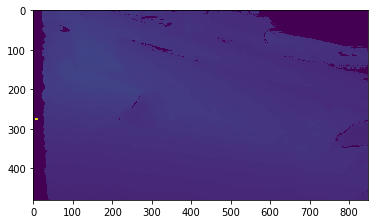

In [620]:
from IPython.display import clear_output

for i in range(len(d435_frames)):
    clear_output(wait=True)
    plt.imshow(d435_frames[i].get_data())
    plt.show()

In [621]:
points = [get_coordinates(depth) for depth in d435_frames]
pcl = [convert_to_pcl(point) for point in points]

In [622]:
regs = []
tr_mxs = []

for i in range(1, len(points)):
    reg = o3d.registration.registration_icp(pcl[i-1], pcl[i], 5)
    print(i, reg.fitness, reg.inlier_rmse)
    tr_mx = reg.transformation
    regs.append(reg)
    tr_mxs.append(tr_mx)

1 0.9997550620509471 0.009886470926716056
2 1.0 0.03015886505837109
3 1.0 0.04062533299082821
4 0.9998353841721882 0.10079314098784306
5 0.9995095635115253 0.16828656673578513
6 0.9987754102375704 0.19649304474429605
7 1.0 0.1274923188820028
8 0.993701173872142 0.0547100526601321
9 1.0 0.05019008727511245
10 0.9995476043594489 0.011742637697675685
11 1.0 0.025567781712497985
12 0.9991540478808899 0.044468677059875235
13 0.9999577898780128 0.09010713460011097
14 1.0 0.08595395298471536


In [623]:
def visualise_transf(points0, points1, reg, size=30):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    cor = np.asarray(reg.correspondence_set)
    set0 = points0[cor[:, 0]]
    set1 = points1[cor[:, 1]]
    inds = np.random.choice(len(cor), size=size, replace=False)
    set0 = set0[inds]
    set1 = set1[inds]
    plot_PC(set0, set1, ax1)
    Tset0 = (reg.transformation @ (np.vstack((set0.T, np.ones(set0.shape[0]))))).T
    plot_PC(Tset0, set1, ax2)
    plt.tight_layout()
    plt.show()
    return set0, set1, Tset0


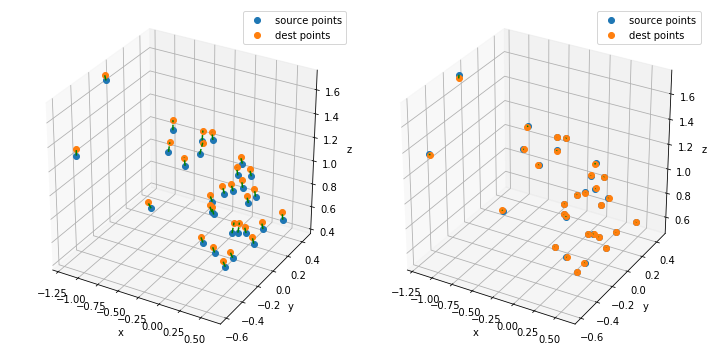

In [624]:
set0, set1, Tset0 = visualise_transf(points[0], points[1], regs[0])

In [625]:
t265_tr_mcs

array([[[ 0.67560929,  0.3674369 , -0.63917307, -0.219076  ],
        [ 0.03740873,  0.8487561 ,  0.52745964,  0.347813  ],
        [ 0.73631018, -0.38026728,  0.55968216,  0.19687   ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.65870455,  0.44428773, -0.60722049, -0.273973  ],
        [-0.01447567,  0.8143769 ,  0.58015577,  0.424475  ],
        [ 0.75226243, -0.37336133,  0.54286513,  0.242354  ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.77233777,  0.41335634, -0.48231825, -0.297646  ],
        [-0.04760926,  0.79483618,  0.60495356,  0.416425  ],
        [ 0.63342539, -0.44426567,  0.63356159,  0.197351  ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],

       [[ 0.87812424,  0.26993797, -0.39500799, -0.299259  ],
        [-0.0105828 ,  0.83638641,  0.54803812,  0.410019  ],
        [ 0.47831561, -0.47706526,  0.73730788,  0.0985125 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]],



In [629]:
T = t265_tr_mcs[0].copy()
tr_mcs1 = [T]
for tr in tr_mxs:
    T = tr @ T
    tr_mcs1.append(T)
    
tr1 = np.vstack(([0,0,0], np.array(tr_mcs1)[:, :3, -1]))

In [632]:
tr1 = np.vstack(([0,0,0], np.array(tr_mxs)[:, :3, -1]))

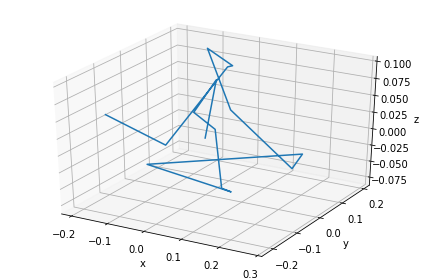

In [633]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(tr1[:,1], tr1[:, 0], tr1[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()

plt.tight_layout()
plt.show()

In [634]:
trajectory = [np.zeros(3)]
R_ = np.eye(3)
poses = [R_]

In [635]:
for i in range(len(tr_mxs)):
    t_est = tr_mxs[0][:3, -1]
    R_est = tr_mxs[0][:3, :3]

    R_ = R_est @ R_
    t = trajectory[-1] + (np.linalg.inv(R_) @ t_est).ravel()
    
    trajectory.append(t) #-t moves point cloud into (0,0) of the initial state 
    poses.append(R_) #R_^-1 translates point cloud into the state of initial frame

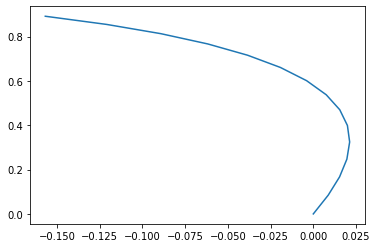

In [636]:
trajectory = np.array(trajectory)
plt.plot(trajectory[:, 0], trajectory[:, 2])

In [637]:
poses

[array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]), array([[ 0.99840627,  0.05642276,  0.00118057],
        [-0.05623659,  0.99642965, -0.06297143],
        [-0.00472938,  0.06280468,  0.99801463]]), array([[ 0.99363647,  0.11262829, -0.0011961 ],
        [-0.11188495,  0.98574412, -0.12565941],
        [-0.01297376,  0.1249936 ,  0.99207272]]), array([[ 0.98572471,  0.16821475, -0.00711303],
        [-0.16654724,  0.96801981, -0.18761574],
        [-0.02467418,  0.18612212,  0.98221675]]), array([[ 0.97472755,  0.22278474, -0.01652791],
        [-0.21983263,  0.94338344, -0.24839747],
        [-0.03974701,  0.24575323,  0.96851718]]), array([[ 0.96072361,  0.2759481 , -0.02937343],
        [-0.27136018,  0.91201114, -0.30757005],
        [-0.05808447,  0.30346058,  0.95107196]]), array([[ 0.94381301,  0.32732476, -0.04555776],
        [-0.32076149,  0.87412721, -0.36471042],
        [-0.07955547,  0.35883161,  0.93000581]]), array([[ 0.92411666,  0.37654738, -0.0649651

In [640]:
def plot_pose(c, pose, ax):
    for i, color in enumerate(['r', 'g', 'b']):
        ax.plot([c[0], pose[0, i]+c[0]], 
                [c[1], pose[1, i]+c[1]],
                [c[2], pose[2, i]+c[2]], color)
    
def plot_poses(trajectory, poses):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(trajectory[:,0], trajectory[:, 1], trajectory[:,2], 'k')
#     for i, pose in enumerate(poses):
#         plot_pose(trajectory[i], pose, ax)
#     ax.plot(points_trajectory_T265[:,0], points_trajectory_T265[:, 1], points_trajectory_T265[:, 2])
    plt.tight_layout()
    plt.show()

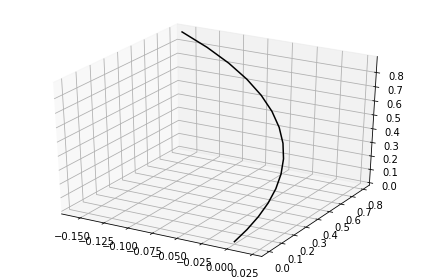

In [641]:
plot_poses(np.array(trajectory), np.array(poses))

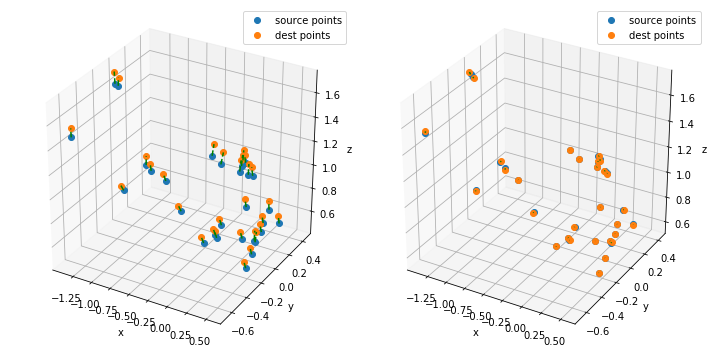

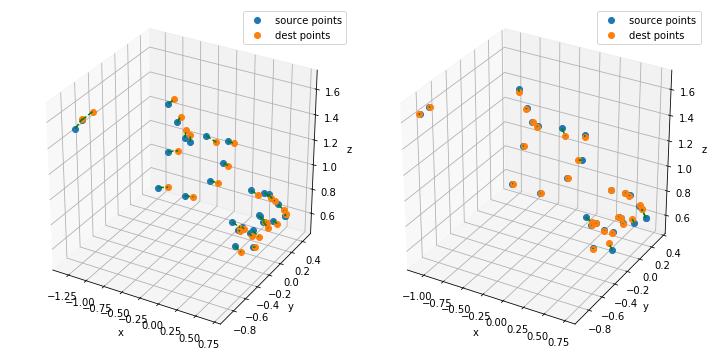

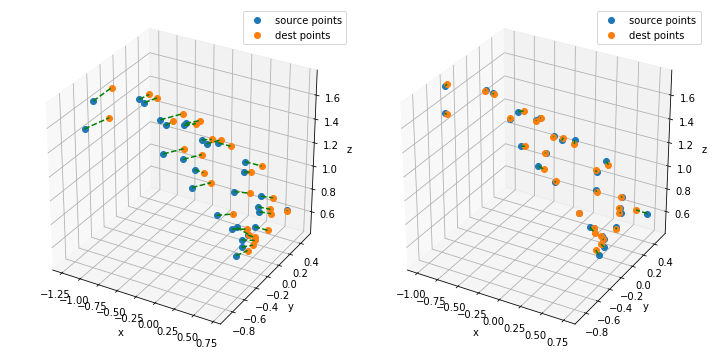

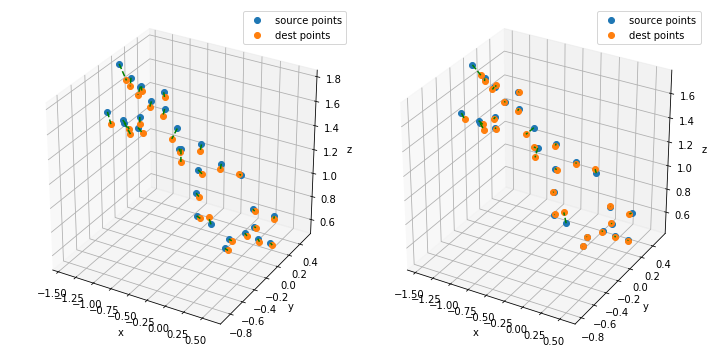

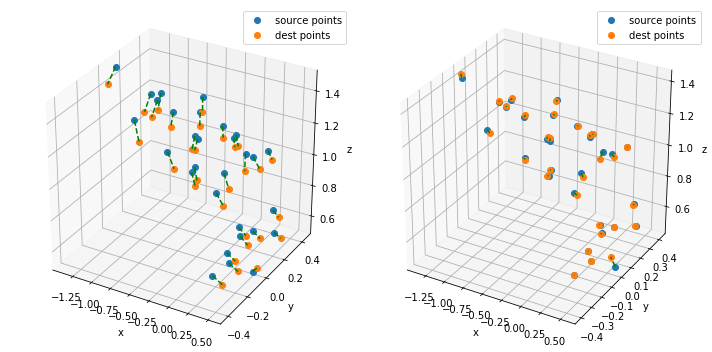

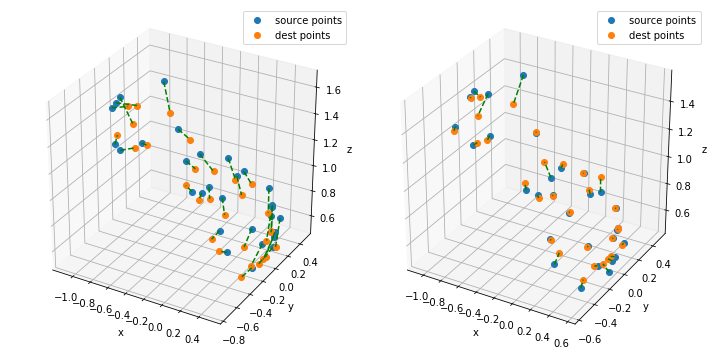

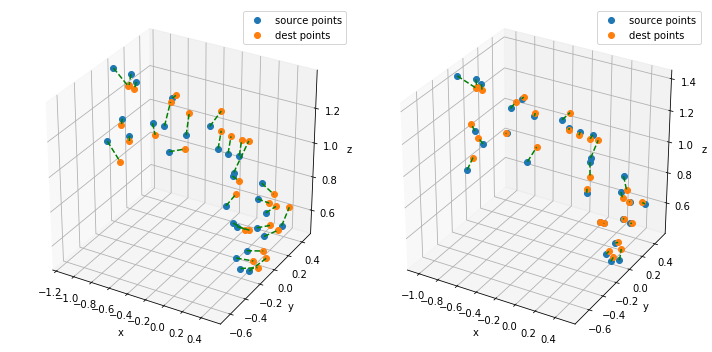

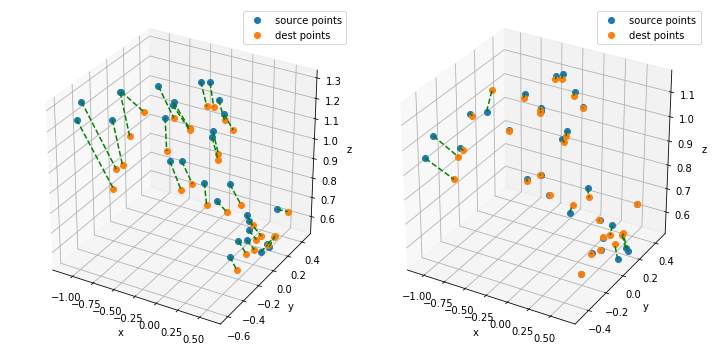

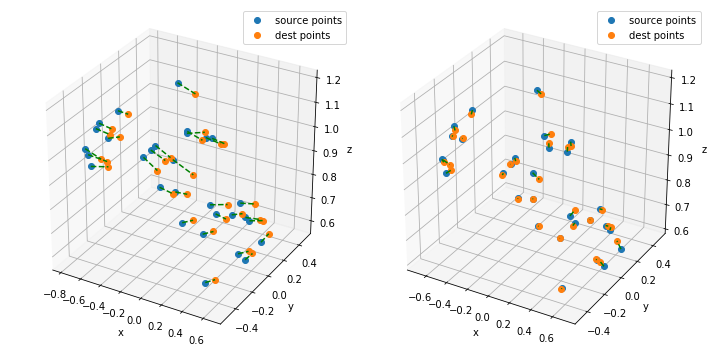

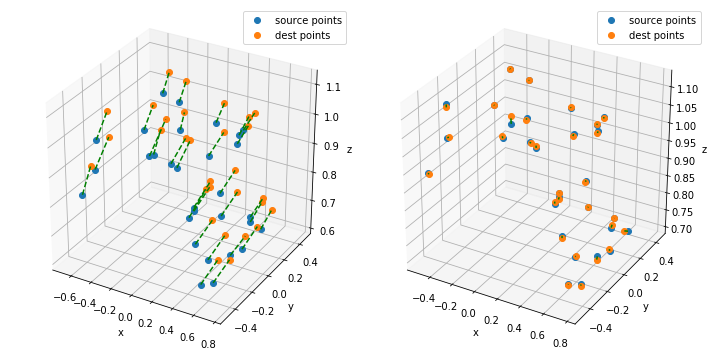

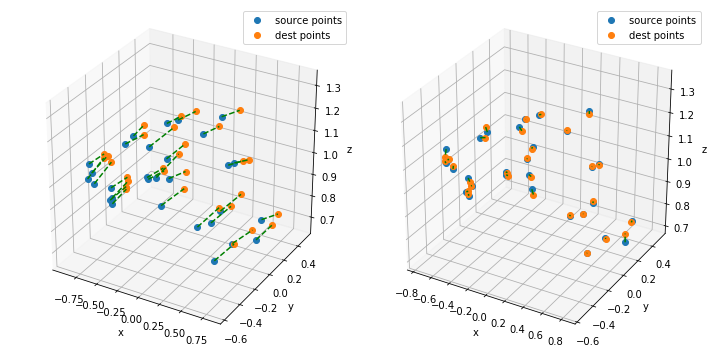

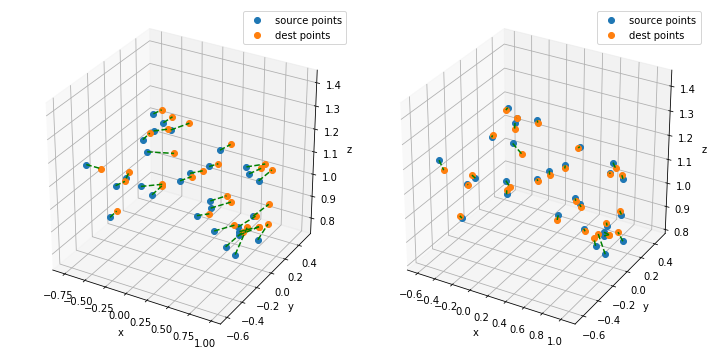

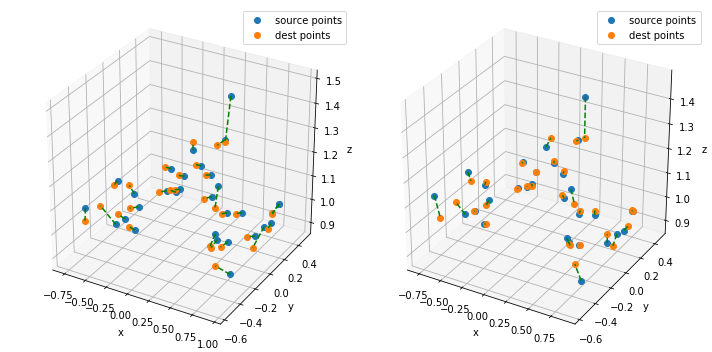

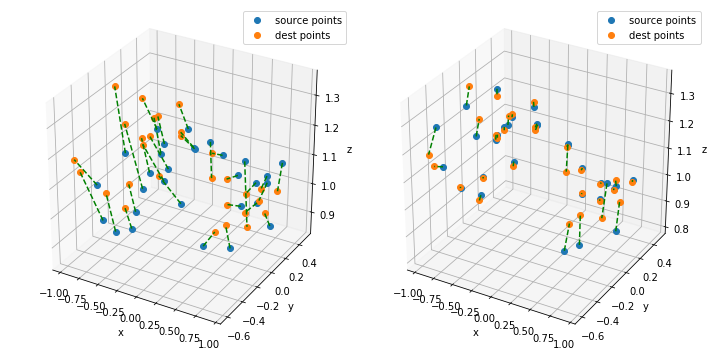

In [242]:
for i in range(len(tr_mxs)):
    _ = visualise_transf(points[i], points[i+1], regs[i])

In [243]:
np.mean(points[0], axis=0)

array([-0.12281945, -0.01571431,  0.87107915], dtype=float32)

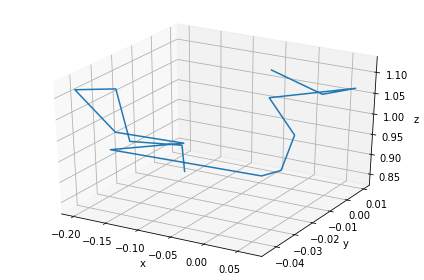

In [244]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
tr = []
for i in range(len(points)):
#     ax.plot(points[i][:50,0], points[i][:50,1], points[i][:50,2], 'o', label=str(i))
    tr.append(np.mean(points[i], axis=0))
tr = np.array(tr)
ax.plot(tr[:,0], tr[:, 1], tr[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()

plt.tight_layout()
plt.show()

In [574]:
points_trajectory_T265 = [[0, 0, 0]]
for pose in t265_frames:
    tr_mx = get_transformation265(pose)
    points_trajectory_T265.append(tr_mx[:3, -1])
points_trajectory_T265 = np.array(points_trajectory_T265)

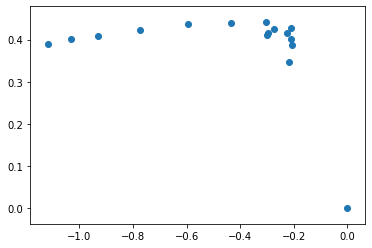

In [590]:
plt.scatter(points_trajectory_T265[:, 0], points_trajectory_T265[:, 1])

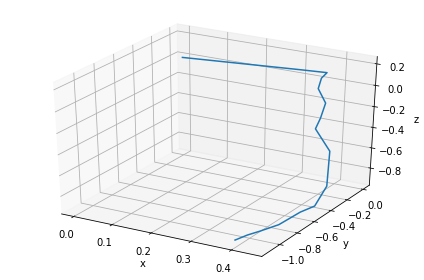

In [576]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(tr[:,0], tr[:, 1], tr[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()
ax.plot(points_trajectory_T265[:,1], points_trajectory_T265[:,0], points_trajectory_T265[:,2])
plt.tight_layout()
plt.show()

In [583]:
t265_tr_mcs = np.array([get_transformation265(pose) for pose in t265_frames])
tr265 = np.vstack(([0, 0, 0], t265_tr_mcs[:, :3, -1]))

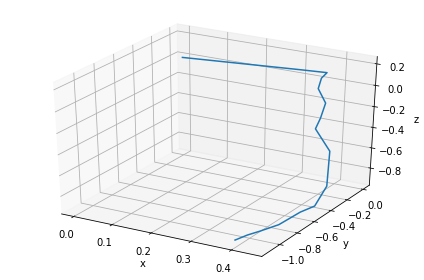

In [584]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(tr[:,0], tr[:, 1], tr[:, 2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# ax.legend()
ax.plot(tr265[:,1], tr265[:,0], tr265[:,2])
plt.tight_layout()
plt.show()

In [252]:
pose.get_pose_data().rotation

x: -0.318505, y: 0.180132, z: 0.130789, w: 0.921413

In [253]:
pose.get_pose_data().translation

x: -1.11862, y: 0.390405, z: -0.92984

In [254]:
data_rot = [float(i.strip('xyzw: ')) for i in str(pose.get_pose_data().rotation).split(', ')]

In [257]:
r = R.from_quat(data_rot)

In [261]:
for i in str(pose.get_pose_data().rotation).split(', '):
    print(i.strip('xyzw: '))

-0.318505
0.180132
0.130789
0.921413


In [262]:
def get_transformation265(pose):
    data = pose.get_pose_data()
    data_rot = [float(i.strip('xyzw: ')) for i in str(data.rotation).split(', ')]
    r = R.from_quat(data_rot)
    rotation = np.array(r.as_dcm())
    translation = np.array([float(i.strip('xyzw: ')) for i in str(data.translation).split(', ')])[np.newaxis].T
    T = np.hstack((rotation, translation))
    T = np.vstack((T, np.array([0, 0, 0, 1])))
    return T

In [267]:
len(points), len(t265_tr_mcs)

(15, 15)

In [269]:
t265_tr_mcs

[array([[ 0.67560929,  0.3674369 , -0.63917307, -0.219076  ],
        [ 0.03740873,  0.8487561 ,  0.52745964,  0.347813  ],
        [ 0.73631018, -0.38026728,  0.55968216,  0.19687   ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.65870455,  0.44428773, -0.60722049, -0.273973  ],
        [-0.01447567,  0.8143769 ,  0.58015577,  0.424475  ],
        [ 0.75226243, -0.37336133,  0.54286513,  0.242354  ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.77233777,  0.41335634, -0.48231825, -0.297646  ],
        [-0.04760926,  0.79483618,  0.60495356,  0.416425  ],
        [ 0.63342539, -0.44426567,  0.63356159,  0.197351  ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.87812424,  0.26993797, -0.39500799, -0.299259  ],
        [-0.0105828 ,  0.83638641,  0.54803812,  0.410019  ],
        [ 0.47831561, -0.47706526,  0.73730788,  0.0985125 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),


In [311]:
corr01 = np.asarray(regs[0].correspondence_set)
corr12 = np.asarray(regs[1].correspondence_set)

set0 = points[0][corr01[:, 0]]
set10 = points[1][corr01[:, 1]]
set12 = points[1][corr12[:, 0]]
set2 = points[2][corr12[:, 1]]

In [292]:
def set2str(s):
    s = s.astype(str)
    s = list(map(lambda x: x[0]+'|'+x[1]+'|'+x[2], s))
    return np.array(s)

In [293]:
set10_ = set2str(set10)
set12_ = set2str(set12)

In [298]:
inds10 = []
inds12 = []
for i in tqdm(range(len(set10_))):
    if set10_[i] in set12_:
        inds10.append(i)
        inds12.append(np.argwhere(set12_==set10_[i])[0])

In [300]:
inds10 = np.array(inds10)

In [301]:
len(inds10), inds10[-1]

(24490, 24489)

In [304]:
inds12 = np.array(inds12).squeeze(1)

In [306]:
inds12, len(inds12)

(array([11462, 11463, 11465, ..., 11667, 11668, 11668], dtype=int64), 24490)

In [312]:
set0 = set0[inds10]
set2 = set2[inds12]
set1 = set10[inds10]

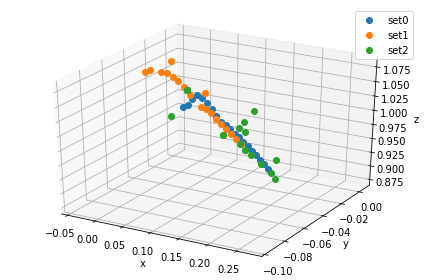

In [319]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(set0[:20,0], set0[:20,1], set0[:20,2], 'o', label='set0')
ax.plot(set1[:20,0], set1[:20,1], set1[:20,2], 'o', label='set1')
ax.plot(set2[:20,0], set2[:20,1], set2[:20,2], 'o', label='set2')
# ax.plot([set0[i,0],set1[i,0]], [set0[i,1], set1[i,1]], [set0[i,2], set1[i,2]], 'g--')
# ax.plot([set1[i,0],set2[i,0]], [set1[i,1], set2[i,1]], [set1[i,2], set2[i,2]], 'r--')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.tight_layout()
plt.show()

In [336]:
set10_tr = (regs[0].transformation @ np.hstack((set0, np.ones((set0.shape[0], 1)))).T).T
set20_tr = (regs[1].transformation @ set10_tr.T).T
set21_tr = (regs[1].transformation @ np.hstack((set1, np.ones((set1.shape[0], 1)))).T).T

In [337]:
set10_tr = set10_tr[:, :-1]
set20_tr = set20_tr[:, :-1]
set21_tr = set21_tr[:, :-1]

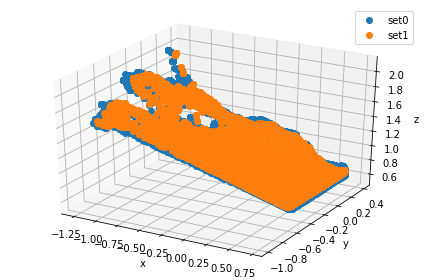

In [339]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(set10_tr[:,0], set10_tr[:,1], set10_tr[:,2], 'o', label='set0')
# ax.plot(set1[:,0], set1[:,1], set1[:,2], 'o', label='set1')

# ax.plot(set20_tr[:,0], set20_tr[:,1], set20_tr[:,2], 'o', label='set0')
ax.plot(set21_tr[:,0], set21_tr[:,1], set21_tr[:,2], 'o', label='set0')
ax.plot(set2[:,0], set2[:,1], set2[:,2], 'o', label='set1')
# ax.plot(set2[:20,0], set2[:20,1], set2[:20,2], 'o', label='set2')
# ax.plot([set0[i,0],set1[i,0]], [set0[i,1], set1[i,1]], [set0[i,2], set1[i,2]], 'g--')
# ax.plot([set1[i,0],set2[i,0]], [set1[i,1], set2[i,1]], [set1[i,2], set2[i,2]], 'r--')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.tight_layout()
plt.show()

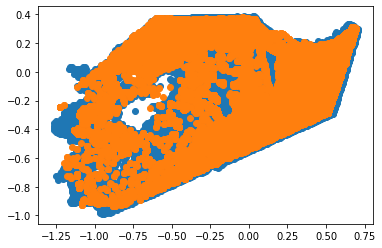

In [342]:
plt.plot(set20_tr[:,0], set20_tr[:,1], 'o', label='set0')
plt.plot(set2[:,0], set2[:,1], 'o', label='set1')

In [347]:
set12_tr = (np.linalg.inv(regs[1].transformation) @ np.hstack((set2, np.ones((set2.shape[0], 1)))).T).T
set01_tr = (np.linalg.inv(regs[0].transformation) @ np.hstack((set1, np.ones((set1.shape[0], 1)))).T).T
set02_tr = (np.linalg.inv(regs[0].transformation) @ set12_tr.T).T

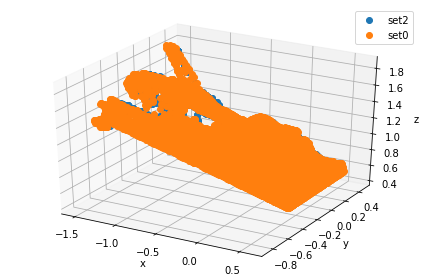

In [349]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(set10_tr[:,0], set10_tr[:,1], set10_tr[:,2], 'o', label='set0')
# ax.plot(set1[:,0], set1[:,1], set1[:,2], 'o', label='set1')

# ax.plot(set20_tr[:,0], set20_tr[:,1], set20_tr[:,2], 'o', label='set0')
ax.plot(set02_tr[:,0], set02_tr[:,1], set02_tr[:,2], 'o', label='set2')
ax.plot(set0[:,0], set0[:,1], set0[:,2], 'o', label='set0')
# ax.plot(set2[:20,0], set2[:20,1], set2[:20,2], 'o', label='set2')
# ax.plot([set0[i,0],set1[i,0]], [set0[i,1], set1[i,1]], [set0[i,2], set1[i,2]], 'g--')
# ax.plot([set1[i,0],set2[i,0]], [set1[i,1], set2[i,1]], [set1[i,2], set2[i,2]], 'r--')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.tight_layout()
plt.show()

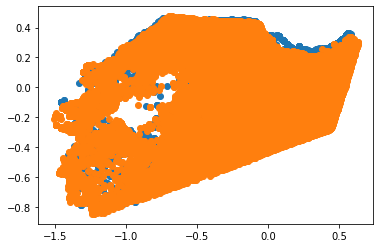

In [353]:
plt.plot(set02_tr[:,0], set02_tr[:,1], 'o', label='set2')
plt.plot(set1[:,0], set1[:,1], 'o', label='set1')

with transformation matrices from t265

In [360]:
t265_435_mcs = [tr @ np.linalg.inv(tm_T265toD435) for tr in t265_tr_mcs]

In [384]:
set0_265 = (np.linalg.inv(tm_T265toD435) @ np.hstack((set0, np.ones((set0.shape[0], 1)))).T).T
set_265_init = (np.linalg.inv(t265_tr_mcs[0]) @ np.linalg.inv(tm_T265toD435) @  np.hstack((set0, np.ones((set0.shape[0], 1)))).T).T
set1_265 = (np.linalg.inv(tm_T265toD435) @ np.hstack((set1, np.ones((set1.shape[0], 1)))).T).T
set2_265 = (np.linalg.inv(tm_T265toD435) @ np.hstack((set2, np.ones((set2.shape[0], 1)))).T).T

In [390]:
set0_265 = (tm_T265toD435 @ np.hstack((set0, np.ones((set0.shape[0], 1)))).T).T
set_265_init = (np.linalg.inv(t265_tr_mcs[0]) @ tm_T265toD435 @  np.hstack((set0, np.ones((set0.shape[0], 1)))).T).T
set1_265 = (tm_T265toD435 @ np.hstack((set1, np.ones((set1.shape[0], 1)))).T).T
set2_265 = (tm_T265toD435 @ np.hstack((set2, np.ones((set2.shape[0], 1)))).T).T

In [391]:
set00_tr = (t265_tr_mcs[0] @ set_265_init.T).T
set10_tr = (t265_tr_mcs[1] @ set_265_init.T).T
set20_tr = (t265_tr_mcs[2] @ set_265_init.T).T
# set21_tr = (regs[1].transformation @ np.hstack((set1, np.ones((set1.shape[0], 1)))).T).T

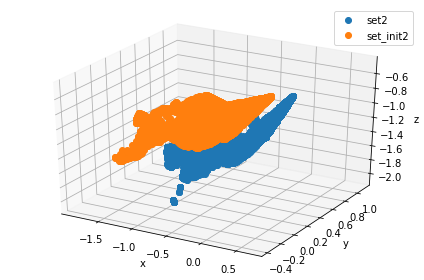

In [392]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.plot(set10_tr[:,0], set10_tr[:,1], set10_tr[:,2], 'o', label='set0')
# ax.plot(set_265_init[:,0], set_265_init[:,1], set_265_init[:,2], 'o', label='set0_init')
# ax.plot(set0_265[:,0], set0_265[:,1], set0_265[:,2], 'o', label='set0')
# ax.plot(set1_265[:,0], set1_265[:,1], set1_265[:,2], 'o', label='set1')
ax.plot(set2_265[:,0], set2_265[:,1], set2_265[:,2], 'o', label='set2')

# ax.plot(set00_tr[:,0], set00_tr[:,1], set00_tr[:,2], 'o', label='set_init0')
# ax.plot(set10_tr[:,0], set10_tr[:,1], set10_tr[:,2], 'o', label='set_init1')
ax.plot(set20_tr[:,0], set20_tr[:,1], set20_tr[:,2], 'o', label='set_init2')

# ax.plot(set20_tr[:,0], set20_tr[:,1], set20_tr[:,2], 'o', label='set0')
# ax.plot(set02_tr[:,0], set02_tr[:,1], set02_tr[:,2], 'o', label='set2')
# ax.plot(set0[:,0], set0[:,1], set0[:,2], 'o', label='set0')
# ax.plot(set2[:20,0], set2[:20,1], set2[:20,2], 'o', label='set2')
# ax.plot([set0[i,0],set1[i,0]], [set0[i,1], set1[i,1]], [set0[i,2], set1[i,2]], 'g--')
# ax.plot([set1[i,0],set2[i,0]], [set1[i,1], set2[i,1]], [set1[i,2], set2[i,2]], 'r--')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend()
plt.tight_layout()
plt.show()

In [409]:
d435_frames[0].get_distance(100, 100)

1.371000051498413